# Titanic

- 캐글의 과정

1. 캐글을 하기 위해서는 우선 Description에서 원하는 것이 무엇인지 알야되고, 요구조건을 파악해야한다.

2. 데이터를 다운받아서 훑어본다. 출력값은 어떻게 해야하는지 어떤 값을 가지고 조율할지(Data engineering)을 통하여 의미있는 값으로 간추린다.

3. 이제 이 의미있는 값들을 다양한 머신러닝을 통하여 TRAIN을 하여 최종적인 값을 내는 하나의 큰 기계를 만든다.

4. 이제 TEST를 넣고 제출에 해당하는 값의 result를 내어, 새로운 dataframe에 저장하여 제출한다.

위의 과정에 따라 전통적인 머신러닝을 통하여 분류를 해보도록 하겠다.

## Kaggle 계정 연동

In [2]:
 !ls -lha kaggle.json

!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6


# 캐글연동을 위한 토큰 입력
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


# 버전이 1.5.6 이 아니면, 진행할 수 없다
! kaggle -v 

  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=49c80bcd91ac1fc79d85d0614865e69dd9fcfebc3bd598fae21da6f3acb5c7b4
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Kaggle API 1.5.6
-rw-r--r-- 1 root root 66 Feb 12 11:47 kaggle.json
Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)
Processing /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01/kaggle-1.5.6-py3-none-any.whl
Kaggle API 1.5.6


## 연동된 계정을 통하여 데이터를 다운 받고 압축 풀기

In [3]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 24.2MB/s]


In [0]:
import zipfile
import os

os.mkdir('/content/input')

zip_ref = zipfile.ZipFile("/content/titanic.zip", 'r')
zip_ref.extractall("/content/input")
zip_ref.close()

# 데이터 엔지니어링

- 해당 문제에서 원하는 질문은  
“what sorts of people were more likely to survive?  
어떤 클래스의 사람들의 더 잘 살 것 같은지?

### 필요한 라이브러리 불러오기

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline


### 데이터 파악

In [6]:
train_data = pd.read_csv('/content/input/train.csv')
ex_results = pd.read_csv('/content/input/gender_submission.csv')
print(ex_results)
# test를 통해서 나온 값을 사람 수 : survived  예측한 결과를 캐글에 저장된 답과 비교하여 점수가 측정됨.
print(train_data)
train_data.columns

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
     PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0              1         0       3  ...   7.2500   NaN         S
1              2         1       1  ...  71.2833   C85         C
2              3         1       3  ...   7.9250   NaN         S
3              4         1       1  ...  53.1000  C123         S
4              5         0       3  ...   8.0500   NaN         S
..           ...       ...     ...  ...      ...   ...       ...
886          887         0       2  ...  13.0000   NaN         S
887          888         1       1  ...  30.0000   B42         S
888          889         0       3  ...  23.4500   NaN         S
88

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
print(train_data.iloc[:10,[0,1,2]])

print(train_data.iloc[:10,[3,4,5,6]])

print(train_data.iloc[:10,[7,8,9,10,11]])

   PassengerId  Survived  Pclass
0            1         0       3
1            2         1       1
2            3         1       3
3            4         1       1
4            5         0       3
5            6         0       3
6            7         0       1
7            8         0       3
8            9         1       3
9           10         1       2
                                                Name     Sex   Age  SibSp
0                            Braund, Mr. Owen Harris    male  22.0      1
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1
2                             Heikkinen, Miss. Laina  female  26.0      0
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1
4                           Allen, Mr. William Henry    male  35.0      0
5                                   Moran, Mr. James    male   NaN      0
6                            McCarthy, Mr. Timothy J    male  54.0      0
7                     Palsson, Master. Gosta 

- ex_results 를 보아 사람 수에 따라 survived를 예측해야된다는 것을 알 수있다.
- train_data의 columns와 해당 competition의 data 부분을 살펴보면 컬럼에 대한 설명이 잘 되어있다.

```
Variable Notes
pclass: A proxy for socio-economic   status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5  

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)  

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.
```
  - Pasengerld : 사람의 수
  - Survived : 살았는지 죽었는지  
  (0 = no, 1 = yes)
  
  - Pclass : 티켓의 클래스  
  (1 = 1st, 2 = 2nd, 3 = 3rd)
  - Name : 이름 
  - Sex : 성별
  - Age : 나이
  - SibSp : sibling, spouse
  - Parch :parent, child
  - Ticket :ticket number
  - Fare : 두려움 정도
  - Cabin : 객실
  - Embarked : 승선지


### 기준 세우기
- 데이터 정제는 각자의 기준에 따라서 진행한다.
- 나의 기준은 heatmap 으로 일단 survived와 관련성 있는 변수를 추려본다. 
- heatmap은 연속적인 데이터에 대한 상관관계를 봄으로 비연속적 데이터에 대해서 연속적인 데이터로 바꿔줘야한다.  
ex) Name,Sex, Age(Nan 값 존재), Cabin(Nan값 존재),Ticket(a,b,c 다양성 존재), 객실(a,b,c..),행선지(s,c,q) 

### Name

In [0]:
#Name으로 남, 여를 얻을 수 있고 가족 관계를 얻을 수 있을 것 같았는데 데이터를 찾아보니,
#딱히 관계는 없는 듯 하여 삭제한다.
train_data = train_data.drop(['Name'], axis = 1)

### Sex

In [0]:
#Sex 보면 female과 male로 되어있다 이를 함수를 통하여 1, 0 으로 바꾼다.

def sex_to_num(data):
  if 'female' == data:
    return 1
  elif 'male' == data:
    return 0
    
train_data['Sex'] = train_data['Sex'].apply(sex_to_num)

In [10]:
print(train_data['Sex'].head(n=5))

0    0
1    1
2    1
3    1
4    0
Name: Sex, dtype: int64


### Age, Cabin, Embarked

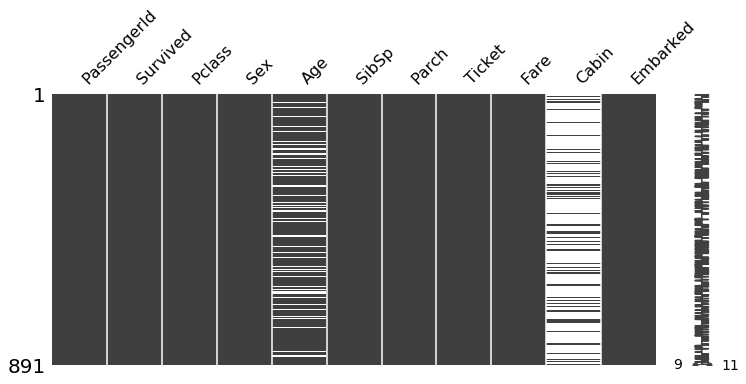

In [11]:
import missingno as msno
# 다음 널값을 알아보는 라이브러리를 통하여
#Age,Cabin(비연속)의 데이터를 보면 Nan 값이 존재하는 것을 알 수 있다.
msno.matrix(train_data,figsize=(12,5))

In [0]:
train_data['Age'].fillna(0,inplace=True)
train_data['Cabin'].fillna(str(0),inplace=True)
train_data['Embarked'].fillna(0,inplace=True)

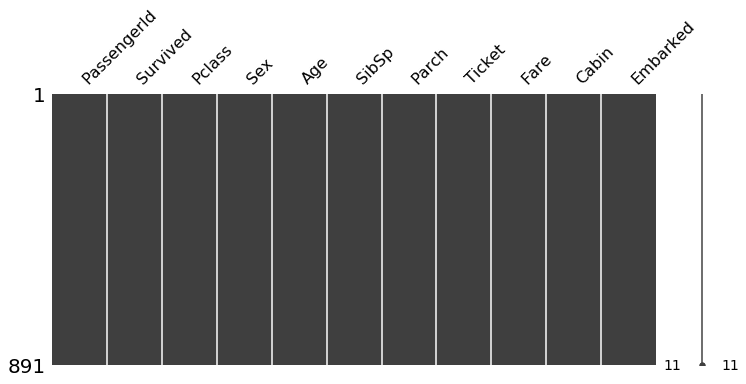

In [13]:
# null 값이 0으로 채워졌기 때문에 없어졌음을 확인할 수 있다.
msno.matrix(train_data,figsize=(12,5))

In [14]:
#이를 전체 평균이 아니고, 값이 있는 곳에서 랜덤으로 100개씩 추려서 평균을 한다.
import random

def random_age(x):
  sum = 0
  for i in range (100):
    num = random.choice(train_data['Age']) 
    if num == 0:
      continue
    sum += num
  return int(sum/100)

# 0 이 확인된다.
print(train_data['Age'].head(n=20))

0     22.0
1     38.0
2     26.0
3     35.0
4     35.0
5      0.0
6     54.0
7      2.0
8     27.0
9     14.0
10     4.0
11    58.0
12    20.0
13    39.0
14    14.0
15    55.0
16     2.0
17     0.0
18    31.0
19     0.0
Name: Age, dtype: float64


In [15]:
for index, data in enumerate(train_data['Age']):
  if data == 0:
    train_data['Age'].loc[index] = random_age(train_data['Age'])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
# 0 값이 랜덤 평균 값으로 채워졌다.
print(train_data['Age'].head(n=20))

0     22.0
1     38.0
2     26.0
3     35.0
4     35.0
5     22.0
6     54.0
7      2.0
8     27.0
9     14.0
10     4.0
11    58.0
12    20.0
13    39.0
14    14.0
15    55.0
16     2.0
17    25.0
18    31.0
19    21.0
Name: Age, dtype: float64


- Cabin 기준
```
0 : random 1 ~ 6
A : 1
B : 2
C : 3
D : 4
E : 5
F : 6
G : 7
```

In [17]:
for index, data in enumerate(train_data['Cabin']):
  if data[0] == 'A':
    train_data['Cabin'].loc[index] = 1
  elif data[0] == 'B':
    train_data['Cabin'].loc[index] = 2
  elif data[0] == 'C':
    train_data['Cabin'].loc[index] = 3
  elif data[0] == 'D':
    train_data['Cabin'].loc[index] = 4
  elif data[0] == 'E':
    train_data['Cabin'].loc[index] = 5
  elif data[0] == 'F':
    train_data['Cabin'].loc[index] = 6
  elif data[0] == 'G':
    train_data['Cabin'].loc[index] = 7
  elif data[0] == 0:
    train_data['Cabin'].loc[index] = randint(1,6)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
print(train_data['Cabin'].head(n=5))

0    0
1    3
2    0
3    3
4    0
Name: Cabin, dtype: object


- Embarked 기준
```
1 : C
2 : Q
3 : S
2 개의 null 값 : 랜덤 (1~3)
```

In [19]:
# null 값이 두개가 존재하지만 삭제할 경우 다른 데이터에 대한 타격이 있을 것 같아서 이 또한 랜덤으로 채운다.
for index, data in enumerate(train_data['Embarked']):
  if data == 'C':
    train_data['Embarked'].loc[index] = 1
  elif data == 'Q':
    train_data['Embarked'].loc[index] = 2
  elif data == 'S':
    train_data['Embarked'].loc[index] = 3
  elif data == '0':
    train_data['Embarked'].loc[index] = random.randint(1,3)

print(train_data['Embarked'].head(n=10))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0    3
1    1
2    3
3    3
4    3
5    2
6    3
7    3
8    3
9    1
Name: Embarked, dtype: int64


### 데이터 수정 결과 확인하기

In [20]:
# 확인하기
train_data.head(n=5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,0,3
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,3,1
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,0,3
3,4,1,1,1,35.0,1,0,113803,53.1000,3,3
4,5,0,3,0,35.0,0,0,373450,8.0500,0,3


### ticket을 일단 한번 빼보겠다.

In [0]:
td_train_data=train_data.drop(['Ticket'],axis=1)

In [22]:
td_train_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0,3
1,2,1,1,1,38.0,1,0,71.2833,3,1
2,3,1,3,1,26.0,0,0,7.9250,0,3
3,4,1,1,1,35.0,1,0,53.1000,3,3
4,5,0,3,0,35.0,0,0,8.0500,0,3
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,0,3
887,888,1,1,1,19.0,0,0,30.0000,2,3
888,889,0,3,1,26.0,1,2,23.4500,0,3
889,890,1,1,0,26.0,0,0,30.0000,3,1


In [23]:
td_train_columns = (td_train_data.columns).astype(list)
print(td_train_columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### 데이터 엔지니어링 결과
- Survived 에 해당하는 상관관계 수를 살펴보면 Fare, Sex, Parch 컬럼들이 Survived 와 상관관계가 있음을 볼 수 있다. 

In [0]:
Matt = td_train_data[['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin', 'Embarked']]
Matt = Matt.corr()
mask = np.array(Matt)
mask[np.tril_indices_from(mask)] = False

(8.9, -0.1)

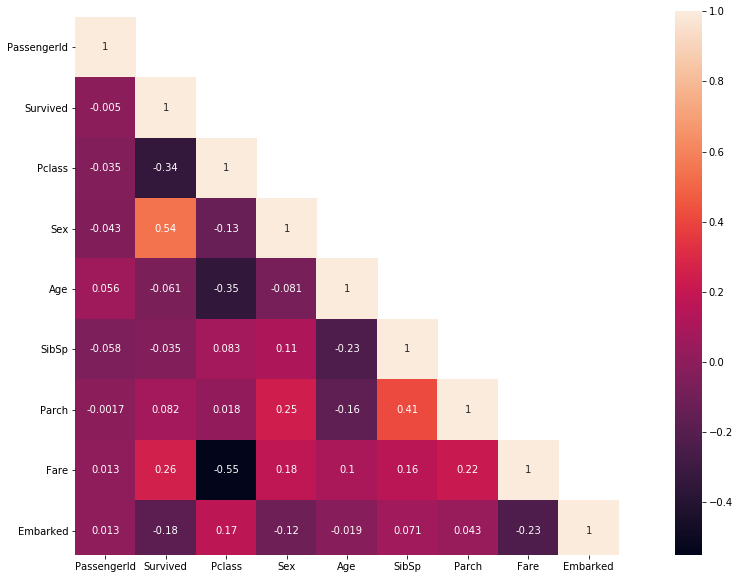

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(Matt, mask=mask, vmax=1,square=True, annot=True)

ax.set_ylim(len(Matt)-0.1,-0.1)

In [0]:
a = train_data['Fare']
b = train_data['Sex']
c = train_data['Parch']

f_train_data = pd.concat([a,b,c], axis = 1)

### Test 셋 엔지니어링

- test 셋도 train을 수정한 것과 똑같은 부분을 수정해줘야한다.

In [0]:
test_data = pd.read_csv('/content/input/test.csv')

In [0]:
test_data['Sex'] = test_data['Sex'].apply(sex_to_num)

a = test_data['Fare']
b = test_data['Sex']
c = test_data['Parch']

f_test_data = pd.concat([a,b,c], axis = 1)

In [78]:
print(f_test_data)

         Fare  Sex  Parch
0      7.8292    0      0
1      7.0000    1      0
2      9.6875    0      0
3      8.6625    0      0
4     12.2875    1      1
..        ...  ...    ...
413    8.0500    0      0
414  108.9000    1      0
415    7.2500    0      0
416    8.0500    0      0
417   22.3583    0      1

[418 rows x 3 columns]


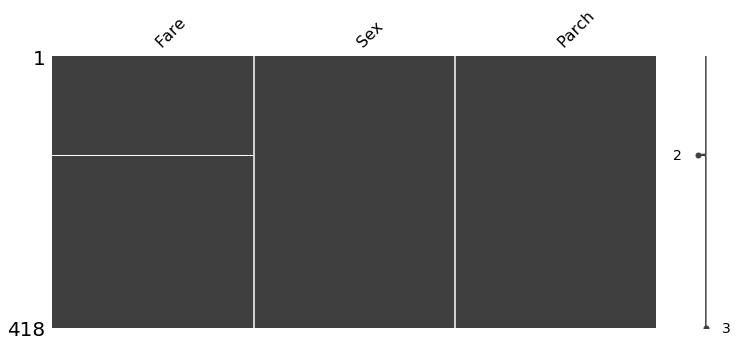

In [79]:
msno.matrix(f_test_data,figsize=(12,5))

In [0]:
f_test_data['Fare'].fillna(method='ffill',inplace=True)

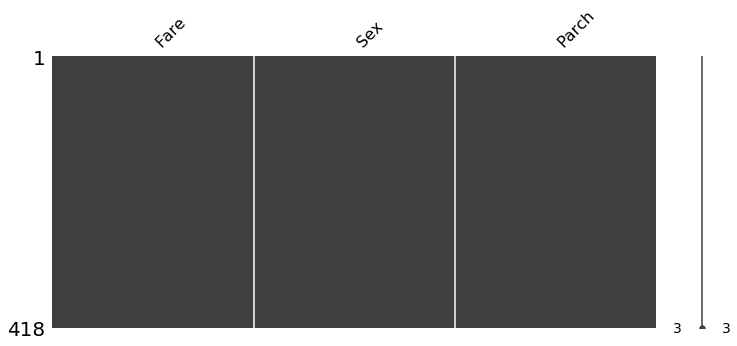

In [82]:
msno.matrix(f_test_data,figsize=(12,5))

In [85]:
# train
print(f_train_data.dtypes)
# test
print(f_test_data.dtypes)

Fare     float64
Sex        int64
Parch      int64
dtype: object
Fare     float64
Sex        int64
Parch      int64
dtype: object


# 데이터 예측 (RandomForest)

- 기본적인 RandomForest로 예측을 해보겠다.

#### 예측 라이브러리 불러오기

In [0]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100, n_jobs = 1, random_state = 0)
clf.fit(f_train_data,train_data['Survived'])
results = clf.predict(f_test_data)

In [92]:
results.shape

(418,)

# 제출

In [93]:
submission = pd.read_csv("/content/input/gender_submission.csv")
submission

submission['Survived'] = results

print(submission.shape)
submission.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [0]:
submission.to_csv("/content/input/results_submission.csv",index=False, header=True)

In [97]:
!kaggle competitions submit -c titanic -f /content/input/results_submission.csv -m "Message"

100% 2.77k/2.77k [00:01<00:00, 1.85kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster

# 캐글 리더보드 점수 : 0.72248